Importing libraries

In [3]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

Hyperparemeters

In [11]:
lr = 23     #learning rate
size = 360     #size of image
iterations = 250
style_wt = 0.0008      #weight given to the style in output
content_wt = 0.8       #content of the reference img

content_image_path = "TamilContentImages/C_image9.jpg"
style_image_path = "TamilStyleImages/S_image9.jpg"

style_layer_wts = [0.8,0.9,1.0,0.9,0.8]    #weight of each layer of nn

Style loss is a term used in neural style transfer algorithms to quantify the difference between the style of a generated image and the style of a style reference image. It measures how well the generated image captures the artistic style of the style reference image.

Loading pretrained model

In [12]:
#VGG is CNN  trained on data set called Imagenet
model = tf.keras.applications.vgg19.VGG19(include_top=False, 
                                          weights="imagenet", input_shape=(size,size,3))
model.trainable=False
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 360, 360, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 360, 360, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 360, 360, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 180, 180, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 180, 180, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 180, 180, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 90, 90, 128)       0     

Preprocessing

In [13]:
def preprocess_img(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(size,size))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return np.expand_dims(img, axis = 0)

Deprocessing for visualization

In [14]:
def deprocess(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    #above are mean values in the rgb channel, representing intensity in each
    #done to focus on capturing the style and content info
    x = x[:, :, ::-1]
    #imagenet images are in bgr so fixing it accordingly
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def display_image(img):
    if len(img.shape) == 4: #check (1,h,w,channels) and remove batch
        img = img[0,:,:,:]

    img = deprocess(img)

    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.show()

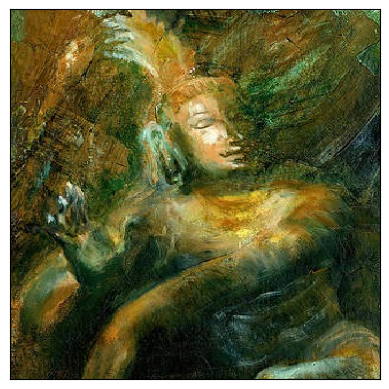

In [15]:
display_image(preprocess_img(style_image_path))

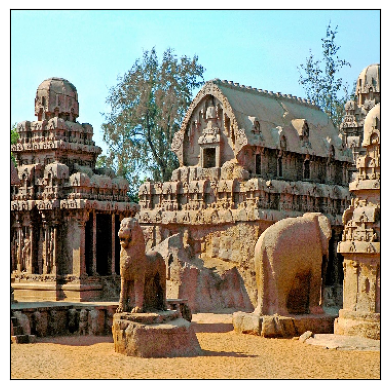

In [16]:
display_image(preprocess_img(content_image_path))

Content part

In [17]:
content_layer = 'block3_conv4'

content_model = tf.keras.models.Model(
    inputs = model.input,
    outputs = model.get_layer(content_layer).output
)

Style part

In [19]:
style_layers = [
    'block1_conv1', 'block2_conv2',
    'block3_conv3', 'block4_conv4',
    'block5_conv2'    
] # layers from vgg19 that capture diff info

style_models = [
    tf.keras.models.Model(inputs=model.input, outputs = model.get_layer(layer).output)
    for layer in style_layers
]

Content cost

In [20]:
def content_cost(content_img, generated_img):
    C = content_model(content_img)
    G = content_model(generated_img)
    cost = tf.reduce_mean(tf.square(C-G))/(4*G.shape[0]*G.shape[1]*3)
    return cost

Style cost

In [21]:
'''The Gram matrix is used in neural style transfer 
to measure the style similarity between two feature maps. 
It represents the correlations between different channels, 
which capture the texture and patterns present in the feature map.'''
def gram_matrix(M):
    num_channels = tf.shape(M)[-1] #find no of channels
    M = tf.reshape(M, shape=(-1, num_channels))
    n = tf.shape(M)[0]
    G = tf.matmul(tf.transpose(M), M)
    return G 

In [22]:
def style_cost(style_img, generated_img):
    total_cost = 0
    
    for i, style_model in enumerate(style_models):
        S = style_model(style_img)
        G = style_model(generated_img)
        GS = gram_matrix(S)
        GG = gram_matrix(G)
        current_cost = style_layer_wts[i] * tf.reduce_mean(tf.square(GS - GG))/(2*GS.shape[0]*GS.shape[0]*3)**2
        total_cost += current_cost
    return total_cost

Generating image

In [24]:
content_image_preprocessed = preprocess_img(content_image_path)
style_image_preprocessed = preprocess_img(style_image_path)
generated_image = tf.Variable(content_image_preprocessed, dtype=tf.float32)

generated_images = []
costs = []

min_cost=1*10**12
optimizer = tf.optimizers.Adam(learning_rate=lr)

for i in range(iterations):
    
    with tf.GradientTape() as tape:
        J_content = content_cost(content_img=content_image_preprocessed, generated_img=generated_image)
        J_style = style_cost(style_img=style_image_preprocessed, generated_img=generated_image)
        J_total = content_wt * J_content + style_wt * J_style
    
    gradients = tape.gradient(J_total, generated_image)
    optimizer.apply_gradients([(gradients, generated_image)])
    
    costs.append(J_total.numpy())
    
    if i % 10 == 0:
        if(J_total<min_cost):
            generated_images.append(generated_image.numpy())
            min_cost=J_total
        print("Iteration:{}/{}, Total Cost:{}, Style Cost: {}, Content Cost: {}".format(i+1, iterations, J_total, J_style, J_content))

Iteration:1/250, Total Cost:87569.484375, Style Cost: 109461856.0, Content Cost: 0.0
Iteration:11/250, Total Cost:7165.71533203125, Style Cost: 8191229.0, Content Cost: 765.915283203125
Iteration:21/250, Total Cost:1408.0867919921875, Style Cost: 1004770.375, Content Cost: 755.338134765625
Iteration:31/250, Total Cost:926.9849853515625, Style Cost: 469461.25, Content Cost: 689.2698974609375
Iteration:41/250, Total Cost:627.97900390625, Style Cost: 190627.75, Content Cost: 594.345947265625
Iteration:51/250, Total Cost:516.603759765625, Style Cost: 130943.421875, Content Cost: 514.811279296875
Iteration:61/250, Total Cost:448.1472473144531, Style Cost: 101231.1875, Content Cost: 458.9528503417969
Iteration:71/250, Total Cost:404.2783508300781, Style Cost: 81542.8828125, Content Cost: 423.8050231933594
Iteration:81/250, Total Cost:375.0027770996094, Style Cost: 68523.7109375, Content Cost: 400.2297668457031
Iteration:91/250, Total Cost:354.1318359375, Style Cost: 60752.9765625, Content Co

Loss plot

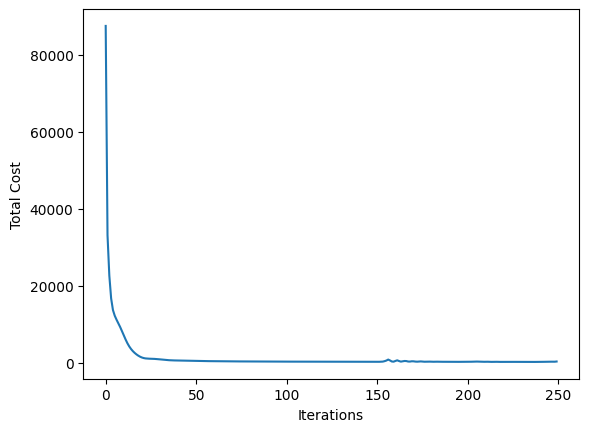

In [25]:
plt.plot(range(iterations), costs)
plt.xlabel("Iterations")
plt.ylabel("Total Cost")
plt.show()

Visualizing final image

In [26]:
image = Image.fromarray(deprocess(generated_images[-1][0]))

<function matplotlib.pyplot.show(close=None, block=None)>

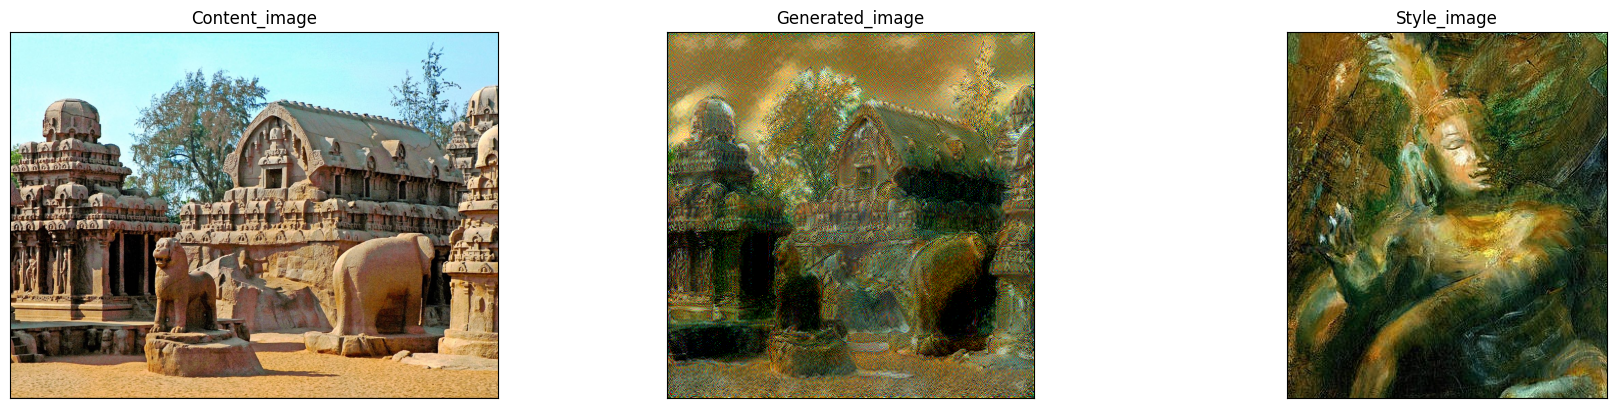

In [31]:
plt.figure(figsize=(24,8))
dict_title={1:"Content_image",2:"Generated_image",3:"Style_image"}
images={1:tf.keras.preprocessing.image.load_img(content_image_path),2:image,3:tf.keras.preprocessing.image.load_img(style_image_path)}
for i in range(1,4):
    plt.subplot(2,4,i)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(dict_title[i])
plt.savefig('out.png')
plt.show